In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 200

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score
from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from skrub import TableVectorizer

# EDA

In [2]:
PATH = "./dataproject2025.csv"
df = pd.read_csv(PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(30))

if "DP" in df.columns:
    print("DP distribution:")
    display(df["DP"].describe())
else:
    print("No DP column found — vérifie le nom exact dans le fichier de description.")

Shape: (1086236, 39)
Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']


,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,fico_range_high,funded_amnt,grade,home_ownership,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_tl,num_il_tl,num_rev_accts,open_acc,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,759.0,4800.0,B,MORTGAGE,2.0,10.99,220.0,25.0,25.0,0.0,25.0,2.0,4.0,1.0,7.0,3.0,0.0,0.0,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,734.0,27050.0,B,OWN,0.0,10.99,326.0,16.0,6.0,4.0,16.0,2.0,8.0,8.0,15.0,14.0,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,749.0,28000.0,A,MORTGAGE,1.0,7.62,229.0,5.0,2.0,5.0,5.0,4.0,8.0,11.0,15.0,15.0,0.0,0.0,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,719.0,12000.0,B,MORTGAGE,1.0,11.99,193.0,4.0,4.0,3.0,85.0,3.0,4.0,8.0,8.0,9.0,0.0,0.0,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,669.0,27600.0,D,MORTGAGE,1.0,19.97,294.0,4.0,4.0,4.0,4.0,5.0,11.0,4.0,16.0,10.0,0.0,0.0,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086236 entries, 0 to 1086235
Data columns (total 39 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Unnamed: 0               1086236 non-null  int64  
 1   issue_d                  1086236 non-null  int64  
 2   loan duration            1086236 non-null  int64  
 3   annual_inc               1086236 non-null  float64
 4   avg_cur_bal              1086236 non-null  float64
 5   bc_open_to_buy           1086236 non-null  float64
 6   bc_util                  1086236 non-null  float64
 7   delinq_2yrs              1086236 non-null  float64
 8   dti                      1086236 non-null  float64
 9   emp_length               1086236 non-null  object 
 10  emp_title                1086236 non-null  object 
 11  fico_range_high          1086236 non-null  float64
 12  funded_amnt              1086236 non-null  float64
 13  grade                    1086236 non-null 

None

Unnamed: 0              0
purpose                 0
num_actv_bc_tl          0
num_bc_tl               0
num_il_tl               0
num_rev_accts           0
open_acc                0
pub_rec                 0
pub_rec_bankruptcies    0
revol_bal               0
mort_acc                0
revol_util              0
sub_grade               0
target                  0
tax_liens               0
zip_code                0
Pct_afro_american       0
Predictions             0
mths_since_recent_bc    0
mo_sin_rcnt_tl          0
issue_d                 0
emp_length              0
loan duration           0
annual_inc              0
avg_cur_bal             0
bc_open_to_buy          0
bc_util                 0
delinq_2yrs             0
dti                     0
emp_title               0
dtype: int64

No DP column found — vérifie le nom exact dans le fichier de description.


# 1. First Surrogates

In [3]:
df_clean = df.dropna(subset=["Predicted probabilities"])
df_clean = df_clean.dropna()

print("Nb total:", len(df), " / Nb sans NaN:", len(df_clean))


y = df_clean["Predicted probabilities"]
X = df_clean.drop(columns=["Predicted probabilities", "Predictions", "target"])


X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=None, test_size=0.2, random_state=42
)

# Surrogate 1: shallow tree
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Tree R2 (fidelity to DP):", r2_score(y_test, pred_tree))

# Surrogate 2: linear regression
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)
print("Linear R2 (fidelity to DP):", r2_score(y_test, pred_lin))

Nb total: 1086236  / Nb sans NaN: 1086236
Tree R2 (fidelity to DP): 0.7384950416435333
Linear R2 (fidelity to DP): 0.9644213360652752


/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


The R2 indicates that our surrogates approximate pretty well the default blackbox model.

Let's try to do an interpretation analysis thanks to our surrogates for first conclusions:

|--- int_rate <= 14.39
|   |--- int_rate <= 10.74
|   |   |--- grade_B <= 0.50
|   |   |   |--- value: [0.06]
|   |   |--- grade_B >  0.50
|   |   |   |--- value: [0.11]
|   |--- int_rate >  10.74
|   |   |--- grade_C <= 0.50
|   |   |   |--- value: [0.14]
|   |   |--- grade_C >  0.50
|   |   |   |--- value: [0.20]
|--- int_rate >  14.39
|   |--- loan duration <= 0.50
|   |   |--- int_rate <= 17.82
|   |   |   |--- value: [0.22]
|   |   |--- int_rate >  17.82
|   |   |   |--- value: [0.28]
|   |--- loan duration >  0.50
|   |   |--- int_rate <= 17.82
|   |   |   |--- value: [0.30]
|   |   |--- int_rate >  17.82
|   |   |   |--- value: [0.40]



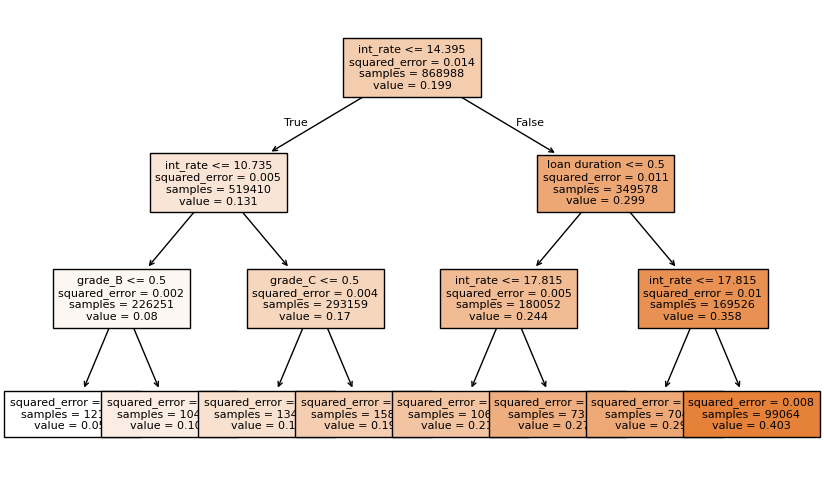

In [4]:
rules = export_text(tree, feature_names=list(X.columns))
print(rules)

plt.figure(figsize=(10, 6))
plot_tree(tree, feature_names=X.columns, filled=True, max_depth=3, fontsize=8)
plt.show()

In [5]:
coefs = pd.Series(lin.coef_, index=X.columns)
coefs_sorted = coefs.sort_values(key=np.abs, ascending=False)
print(coefs_sorted.head(10))

grade_G                0.257120
grade_F                0.222048
grade_E                0.174657
grade_D                0.123065
purpose_wedding       -0.093157
sub_grade_G5           0.086250
sub_grade_G4           0.084953
loan duration          0.083802
emp_title_associate   -0.076877
sub_grade_F5           0.071293
dtype: float64


# 2. Our Blackbox Model

In [6]:
drop_cols = [c for c in ["Predicted probabilities", "Predictions"] if c in df.columns]
y = df["target"].astype(int)
X = df.drop(columns=["target"] + drop_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

best_pipe = Pipeline([
    ("tv", TableVectorizer()),
    ("model", HistGradientBoostingClassifier()),
])

best_pipe.fit(X_train, y_train)
proba_test = best_pipe.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= 0.5).astype(int)

print(f"[TEST] Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"[TEST] AUC:      {roc_auc_score(y_test, proba_test):.4f}")

/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


[TEST] Accuracy: 0.7948
[TEST] AUC:      0.7211


# 3. Cross-fold AUC and R² (TableVectorizer + HGBClassifier)

In [7]:
# Rebuild X / y from df (ensures independence from Step 2 vars)
drop_cols = [c for c in ["Predicted probabilities", "Predictions"] if c in df.columns]
y = df["target"].astype(int).reset_index(drop=True)
X = df.drop(columns=["target"] + drop_cols).reset_index(drop=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_rows = []
for fold_id, (tr_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    pipe = Pipeline([
        ("tv", TableVectorizer()),
        ("model", HistGradientBoostingClassifier()),
    ])
    pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])
    p_val = pipe.predict_proba(X.iloc[val_idx])[:, 1]
    y_val = y.iloc[val_idx]

    fold_auc = roc_auc_score(y_val, p_val)
    fold_r2  = r2_score(y_val, p_val)  # R² on probabilities vs 0/1 labels
    fold_rows.append({"fold": fold_id, "AUC": fold_auc, "R2": fold_r2})

fold_metrics = pd.DataFrame(fold_rows)
print("\nPer-fold metrics:")
print(fold_metrics.to_string(index=False))

print("\nMean ± std across folds:")
print(f"AUC: {fold_metrics['AUC'].mean():.4f} ± {fold_metrics['AUC'].std(ddof=1):.4f}")
print(f" R2: {fold_metrics['R2'].mean():.4f} ± {fold_metrics['R2'].std(ddof=1):.4f}")

/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/


Per-fold metrics:
 fold      AUC       R2
    1 0.722092 0.109006
    2 0.721210 0.107892
    3 0.718766 0.105519
    4 0.722425 0.109777
    5 0.720855 0.107123

Mean ± std across folds:
AUC: 0.7211 ± 0.0014
 R2: 0.1079 ± 0.0017


# 4. Global surrogates for your own model

In [10]:
# 0) Black-box predictions to be mimicked (train & test)
p_train = best_pipe.predict_proba(X_train)[:, 1]
p_test  = best_pipe.predict_proba(X_test)[:, 1]
yhat_train_cls = (p_train >= 0.5).astype(int)
yhat_test_cls  = (p_test  >= 0.5).astype(int)

# 1) Preprocessing for interpretable surrogates (explicit OneHot + optional scaling)
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

preproc_sur = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)),
        ]), cat_cols),
    ],
    remainder="drop"
)

# ----------------------------
# A) Shallow "logistic tree"
# ----------------------------
tree_sur = Pipeline([
    ("prep", preproc_sur),
    ("tree", DecisionTreeClassifier(max_depth=3, random_state=42))
])
tree_sur.fit(X_train, yhat_train_cls)

# Fidelity on class decisions (vs black-box 0.5 threshold)
tree_pred_cls = tree_sur.predict(X_test)
acc_fidelity = accuracy_score(yhat_test_cls, tree_pred_cls)

# Fidelity on probabilities (compare surrogate proba to black-box proba)
tree_pred_proba = tree_sur.predict_proba(X_test)[:, 1]
r2_fidelity_tree = r2_score(p_test, tree_pred_proba)

print(f"[Surrogate A — shallow logistic tree] Fidelity accuracy (labels): {acc_fidelity:.4f}")
print(f"[Surrogate A — shallow logistic tree] Fidelity R² (prob vs prob): {r2_fidelity_tree:.4f}")

# Export readable rules
try:
    feat_names = tree_sur.named_steps["prep"].get_feature_names_out()
    rules_text = export_text(tree_sur.named_steps["tree"], feature_names=list(feat_names), max_depth=3)
except Exception:
    rules_text = export_text(tree_sur.named_steps["tree"], max_depth=3)
print("\n[Surrogate A — rules]\n", rules_text)

# -------------------------------------
# B) r-linear regression (Ridge) on p̂
# -------------------------------------
ridge_sur = Pipeline([
    ("prep", preproc_sur),
    ("scaler", StandardScaler()),         # <-- standardize for coefficient comparability
    ("ridge", Ridge(alpha=1.0))
])
ridge_sur.fit(X_train, p_train)

ridge_pred = ridge_sur.predict(X_test)
r2_fidelity_ridge = r2_score(p_test, ridge_pred)
print(f"\n[Surrogate B — Ridge] Fidelity R² (prob vs prob): {r2_fidelity_ridge:.4f}")

# Top coefficients (absolute magnitude) on standardized features
try:
    feat_names = ridge_sur.named_steps["prep"].get_feature_names_out()
except Exception:
    feat_names = np.array([f"x{i}" for i in range(ridge_sur.named_steps["prep"].transform(X_train).shape[1])])

coefs = pd.Series(ridge_sur.named_steps["ridge"].coef_, index=feat_names)
print("\n[Surrogate B — top |coefficients|]")
print(coefs.abs().sort_values(ascending=False).head(15))

[Surrogate A — shallow logistic tree] Fidelity accuracy (labels): 0.9685
[Surrogate A — shallow logistic tree] Fidelity R² (prob vs prob): -1.4943

[Surrogate A — rules]
 |--- num__int_rate <= 23.88
|   |--- num__int_rate <= 18.02
|   |   |--- num__loan duration <= 0.50
|   |   |   |--- class: 0
|   |   |--- num__loan duration >  0.50
|   |   |   |--- class: 0
|   |--- num__int_rate >  18.02
|   |   |--- num__loan duration <= 0.50
|   |   |   |--- class: 0
|   |   |--- num__loan duration >  0.50
|   |   |   |--- class: 0
|--- num__int_rate >  23.88
|   |--- num__loan duration <= 0.50
|   |   |--- num__funded_amnt <= 8512.50
|   |   |   |--- class: 0
|   |   |--- num__funded_amnt >  8512.50
|   |   |   |--- class: 0
|   |--- num__loan duration >  0.50
|   |   |--- num__mort_acc <= 1.50
|   |   |   |--- class: 1
|   |   |--- num__mort_acc >  1.50
|   |   |   |--- class: 0



/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



[Surrogate B — Ridge] Fidelity R² (prob vs prob): 0.8444

[Surrogate B — top |coefficients|]
num__loan duration          0.037047
cat__grade_D                0.023861
cat__grade_E                0.022879
num__issue_d                0.022283
num__funded_amnt            0.021739
num__dti                    0.018074
cat__grade_C                0.017935
cat__home_ownership_RENT    0.017331
cat__grade_F                0.015482
num__fico_range_high        0.013357
num__int_rate               0.013153
num__mort_acc               0.011917
cat__sub_grade_D4           0.011741
cat__sub_grade_D5           0.011667
cat__sub_grade_C5           0.011422
dtype: float64


/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
